In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# df = pd.read_csv(r'generated_datasets/statlog_with_outliers.csv')
df = pd.read_csv(r'generated_datasets/breast-cancer_with_outliers.csv')
# df = pd.read_csv(r'generated_datasets/covtype_with_outliers.csv')
# df = pd.read_csv(r'generated_datasets/kdd99_with_outliers.csv')

In [3]:
#accessing only numeric columns
df = df._get_numeric_data()

#accessing only the result column
result = df['result']
#drop results column
df = df.drop(columns=['result'])
print(df)

           id  diagnosis  radius_mean  texture_mean  perimeter_mean  \
0      915460          1       15.460         23.95          103.80   
1      868999          0        9.738         11.97           61.24   
2      869224          0       12.900         15.92           83.74   
3    91762702          1       24.630         21.60          165.50   
4      884689          0       11.520         14.93           73.87   
..        ...        ...          ...           ...             ...   
574   8912049          1       19.160         26.60          126.20   
575    908916          0       12.870         19.54           82.67   
576    901088          1       20.440         21.78          133.80   
577   8911230          0       11.330         14.16           71.79   
578    926125          1       20.920         25.09          143.00   

     area_mean  smoothness_mean  compactness_mean  concavity_mean  \
0        731.3          0.11830           0.18700        0.203000   
1        

In [4]:
#This step indicates conversion of df from csv file to dataframe
df = pd.DataFrame(df)
# checking datatypes using info method
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579 entries, 0 to 578
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       579 non-null    int64  
 1   diagnosis                579 non-null    int64  
 2   radius_mean              579 non-null    float64
 3   texture_mean             579 non-null    float64
 4   perimeter_mean           579 non-null    float64
 5   area_mean                579 non-null    float64
 6   smoothness_mean          579 non-null    float64
 7   compactness_mean         579 non-null    float64
 8   concavity_mean           579 non-null    float64
 9   concave points_mean      579 non-null    float64
 10  symmetry_mean            579 non-null    float64
 11  fractal_dimension_mean   579 non-null    float64
 12  radius_se                579 non-null    float64
 13  texture_se               579 non-null    float64
 14  perimeter_se             5

### IMPLEMENTING  t-Distributed Stochastic Neighbor Embedding (t-SNE) FOR THE DATASET

In [5]:
def preprocess_data(df):
    """Preprocess the data: handle missing values and standardize."""
    df_filled = df.fillna(0)  # Fill missing values with 0 or other suitable value
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df_filled)
    return data_scaled

In [6]:
data_scaled = preprocess_data(df)  # Preprocess the data
print("Dataset loaded and preprocessed.")

Dataset loaded and preprocessed.


In [7]:
# Apply t-SNE
tsne = TSNE(n_components=3, random_state=42)
tsne_results = tsne.fit_transform(data_scaled)
encoded_data=tsne_results

print("t-SNE results generated.")

t-SNE results generated.


In [8]:
outlier_points=[]
for i in range(len(encoded_data)):
    if result[i] == -1:
        outlier_points.append(list(encoded_data[i]))
outlier_points = np.array(outlier_points)

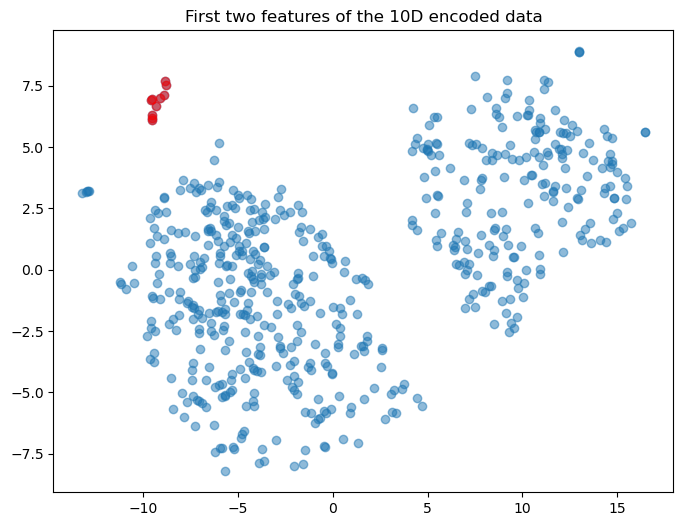

In [9]:
#visualizing the 10D encoded data
# encoded_data = pd.DataFrame(encoded_data, columns=[f'feature_{i}' for i in range(10)])
# outlier_points = pd.DataFrame(outlier_points, columns=[f'feature_{i}' for i in range(10)])

# Plot the 10d encoded data
plt.figure(figsize=(8, 6))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], alpha=0.5)
plt.scatter(outlier_points[:, 0], outlier_points[:, 1], color='red', alpha=0.5)
plt.title('First two features of the 10D encoded data')
plt.show()

# Implementing ELM

In [10]:
# Define the ELMOutlierDetector class
class ELMOutlierDetector:
    def __init__(self, hidden_layer_size=100):
        self.hidden_layer_size = hidden_layer_size

    def fit(self, X):
        input_size = X.shape[1]
        self.hidden_weights = np.random.randn(input_size, self.hidden_layer_size)
        H = np.maximum(0, np.dot(X, self.hidden_weights))  # ReLU activation function
        self.output_weights = np.linalg.pinv(H)

    def predict(self, X):
        H = np.maximum(0, np.dot(X, self.hidden_weights))
        errors = np.linalg.norm(X - np.dot(H, self.hidden_weights), axis=1) #Euclidean distance
        return errors

In [11]:
# Instantiate and use ELMOutlierDetector
from numpy import percentile


elm_detector = ELMOutlierDetector(hidden_layer_size=encoded_data.shape[1])
elm_detector.fit(encoded_data)
outlier_scores = elm_detector.predict(encoded_data)

# Identify outliers
no_of_outliers=int(input("Enter the number of outliers you want to detect: "))
percentage=(len(outlier_scores)-no_of_outliers)/len(outlier_scores)*100
print(f"percentage {percentage}")
threshold = np.percentile(outlier_scores,percentage)
predicted_labels = (outlier_scores > threshold).astype(int)

percentage 96.54576856649395


In [12]:
predicted_points=[]
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 1:
        predicted_points.append(encoded_data[i])
predicted_points = np.array(predicted_points)

# Result visualization

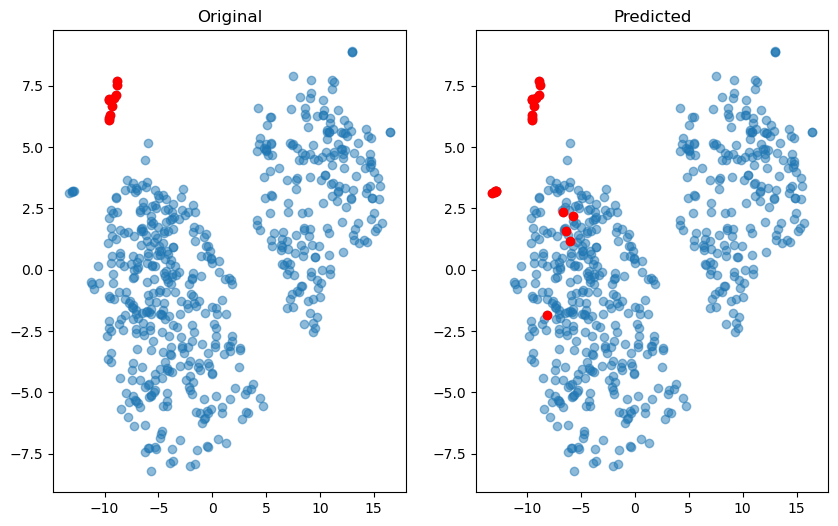

In [13]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], alpha=0.5)
plt.scatter(outlier_points[:, 0], outlier_points[:, 1], color='red')
plt.title('Original')
plt.subplot(1, 2, 2)
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], alpha=0.5)
plt.scatter(predicted_points[:, 0], predicted_points[:, 1], color='red')
plt.title('Predicted')
plt.show()


# Calculating Accuracy

In [14]:
# calculating accuracy using global outliers and original outliers
def accuracy(predicted_labels,result):
    count=0
    for i in range(len(predicted_labels)):
        if predicted_labels[i]==1 and result[i]==-1:
            count+=1
    return count/len(predicted_points)

# calculating precision and recall
def precision_recall(global_outliers,outliers):
    true_positive=0
    false_positive=0
    false_negative=0
    for i in range(len(global_outliers)):
        if global_outliers[i]==1 and outliers[i]==-1:
            true_positive+=1
        if global_outliers[i]==0 and outliers[i]==-1:
            false_positive+=1
        if global_outliers[i]==1 and outliers[i]==1:
            false_negative+=1
            
    precision=true_positive/(true_positive+false_positive)
    recall=true_positive/(true_positive+false_negative)
    return precision,recall

# calculating f1 score
def f1_score(precision,recall):
    return 2*((precision*recall)/(precision+recall))

precision,recall=precision_recall(predicted_labels,result)
print("Accuracy of the model is : ",accuracy(predicted_labels,result))    
print("Precision of the model is : ",precision)
print("Recall of the model is : ",recall)
print("F1 score of the model is : ",f1_score(precision,recall))


Accuracy of the model is :  0.5
Precision of the model is :  1.0
Recall of the model is :  0.5
F1 score of the model is :  0.6666666666666666
